# Download

In [1]:
!wget "https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/kw_to_kw_id.json"
!wget "https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/recipe_id_to_kw_id.json"
!wget "https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/mappers.json"
!wget "https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/image_id_to_recipe_id.json"
# !gdown --fuzzy https://drive.google.com/file/d/1jL4OLNrrgibGREoZxtgZ5laRqLTgtwUx/view?usp=drive_link
!gdown --fuzzy https://drive.google.com/file/d/1CWj-QSZtlFb9rhn-FFjE7c_9SOoYaxv_/view?usp=drive_link
!gdown --fuzzy https://drive.google.com/file/d/182j3iLuC_9Gl2WCUzcP7TeHpymJtfx1R/view?usp=drive_link
# !gdown --fuzzy https://drive.google.com/file/d/1LDCYdpC1nqHQRQpHFrvpI9Ohv49k9gxt/view?usp=drive_link

--2024-12-09 03:35:13--  https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/kw_to_kw_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5678 (5.5K) [text/plain]
Saving to: ‘kw_to_kw_id.json’

kw_to_kw_id.json    100%[===================>]   5.54K  --.-KB/s    in 0s      

2024-12-09 03:35:14 (58.1 MB/s) - ‘kw_to_kw_id.json’ saved [5678/5678]

--2024-12-09 03:35:14--  https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/recipe_id_to_kw_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r drive/MyDrive/Recsys\ project/Entrega\ 3/Trained/ ./

# Libs

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import pickle as pkl
from dataclasses import dataclass
import json
import h5py
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [2]:
reviews_train = pd.read_csv("https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/review_train.csv")
reviews_test = pd.read_csv("https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/review_test.csv")
recipes = pd.read_csv("https://raw.githubusercontent.com/Lord-Kelsier/datasets/refs/heads/master/recipes.csv")

recipes.set_index("RecipeId", inplace=True)

nutrition_facts = [
    'Calories', 'FatContent','SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
    'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent'
]

recipes["RecipeIngredientParts"] = recipes["RecipeIngredientParts"].apply(lambda x:  x.strip("[]").split(","))
recipes["RecipeIngredientParts"] = recipes["RecipeIngredientParts"].apply(lambda x: [] if len(x) == 1 and x[0] == "" else x)
recipes["RecipeIngredientParts"] = recipes["RecipeIngredientParts"].apply(lambda x: [int(i) for i in x])

all_ingredients = set()
list(map(lambda x: all_ingredients.update(x), recipes["RecipeIngredientParts"]))
len(all_ingredients)

6157

In [3]:
len(reviews_train), len(reviews_test)

(1038919, 324627)

In [4]:
with open("mappers.json", "r") as f:
    mappers = json.load(f)
with open("image_id_to_recipe_id.json", "r") as f:
    image_id_to_recipe_id = json.load(f)
current_id_to_original_id = {int(v): int(k) for k, v in mappers['recipe_id_mapper'].items()}
original_id_to_img_id = {int(float(k)): int(v) for k, v in image_id_to_recipe_id.items()}
current_id_to_img_id = {
    current_id: original_id_to_img_id[current_id_to_original_id[current_id]]
    for current_id in current_id_to_original_id
}

with open("recipe_id_to_kw_id.json", "r") as f:
    recipe_id_to_kw_id = json.load(f)
recipe_id_to_kw_id = {int(float(k)): v for k, v in recipe_id_to_kw_id.items()}
item_categories = {k: recipe_id_to_kw_id[v] for k, v in current_id_to_original_id.items()}

In [5]:
recipes["categories"] = recipes.index.map(item_categories)
recipes.head()

RecipeIngredientParts  Calories  \
RecipeId                                                                
0                                  [4686, 4448, 1850, 2281]     170.9   
1         [5798, 3172, 4039, 1824, 2488, 1101, 2985, 111...    1110.7   
2                              [684, 1038, 5984, 4536, 484]     311.1   
3         [230, 1127, 2827, 581, 3810, 2547, 3371, 4036,...     536.1   
4                            [4765, 2695, 3039, 3395, 3641]     103.6   

          FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
RecipeId                                                                       
0                2.5                  1.3                 8.0           29.8   
1               58.8                 16.6               372.8          368.4   
2                0.2                  0.0                 0.0            1.8   
3               24.0                  3.8                 0.0         1558.6   
4                0.4                  0.1                 0.0          959.3   

          CarbohydrateContent  FiberContent  SugarContent  ProteinContent  \
RecipeId                                                                    
0                        37.1           3.6          30.2             3.2   
1                        84.4           9.0          20.4            63.4   
2                        81.5           0.4          77.2             0.3   
3                        64.2          17.3          32.1            29.3   
4                        25.1           4.8          17.7             4.3   

                                          categories  
RecipeId                                              
0         [230, 293, 281, 44, 86, 239, 154, 229, 65]  
1            [126, 170, 135, 51, 240, 106, 154, 223]  
2                           [293, 281, 44, 239, 120]  
3                     [136, 107, 281, 154, 222, 166]  
4                    [293, 48, 281, 44, 54, 120, 65]

In [6]:
reviews_test_big = reviews_test.groupby("AuthorId")["RecipeId"].count()
reviews_test_big = reviews_test_big[reviews_test_big >= 10]
users_big_rev = reviews_test_big.index

In [7]:
from functools import reduce

In [8]:
with open("kw_to_kw_id.json", "r") as f:
    kw_to_kw_id = json.load(f)
kw_id_to_kw = {int(v): k for k, v in kw_to_kw_id.items()}
for user in tqdm(users_big_rev):
    recipes_user = reviews_test[reviews_test["AuthorId"] == user]["RecipeId"].values
    recipes_user = recipes.iloc[recipes_user]
    recipes_user_categories = recipes_user["categories"].values
    reduced = reduce(lambda x, y: set(x).intersection(set(y)), recipes_user_categories)
    if len(reduced) != 0:
        print(user, [kw_id_to_kw[r] for r in reduced])


  0%|          | 0/5127 [00:00<?, ?it/s]

3169 ['Easy']
5295 ['Easy']
19211 ['Vegetable']
63001 ['Easy']
70286 ['Easy']
87918 ['Easy']
98921 ['Easy']
118636 ['Easy']
126218 ['Easy']


In [9]:
sub_recipes = recipes.iloc[reviews_test[reviews_test["AuthorId"] == 3169]["RecipeId"].values].copy()

In [10]:
with open("kw_to_kw_id.json", "r") as f:
    kw_to_kw_id = json.load(f)
kw_id_to_kw = {int(v): k for k, v in kw_to_kw_id.items()}
sub_recipes["categories"] = sub_recipes["categories"].apply(lambda x: [kw_id_to_kw[kw] for kw in x])
sub_recipes

RecipeIngredientParts  Calories  \
RecipeId                                                                
27593              [2122, 394, 684, 3220, 1756, 1970, 3172]    2050.9   
65155                        [4531, 2555, 2709, 5316, 2524]     498.8   
9532      [5367, 3039, 1834, 5316, 1283, 843, 5398, 4157...     208.8   
19530                        [1494, 1970, 1756, 2122, 3172]      86.2   
16927                                          [4073, 4157]     295.2   
147189            [5570, 2012, 4874, 684, 1756, 4752, 3371]     327.2   
48463     [3039, 6126, 2291, 2122, 2729, 3220, 1756, 549...     582.2   
94377                  [5258, 2958, 2844, 3131, 1283, 3306]     247.6   
113587            [2729, 5570, 588, 1561, 1147, 1429, 6126]    2205.6   
16871        [4157, 5829, 903, 3916, 1756, 2122, 3804, 507]    1520.0   
118651                                [2122, 3220, 3172, 6]     230.2   
88985     [2729, 3039, 1834, 2958, 5316, 858, 5570, 5667...     415.3   
9137        [2729, 3039, 2291, 843, 5498, 1756, 4257, 2122]     373.7   

          FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
RecipeId                                                                       
27593           99.7                 62.6               269.6         2792.8   
65155           26.6                 11.5                93.3          881.1   
9532            14.1                  5.1                50.6           67.2   
19530            2.9                  1.7                 7.9          167.5   
16927            9.7                  3.9               149.8          380.6   
147189          21.1                  2.9                 0.0         2965.1   
48463           32.1                 15.1               139.6          904.9   
94377            5.7                  0.6                 0.0            9.7   
113587          80.7                 28.4               308.4        11086.6   
16871           29.8                 17.1                72.2         3753.3   
118651          17.8                 11.2                49.5          364.2   
88985           13.0                  4.7                51.4          674.2   
9137            22.3                 10.1                71.7          761.3   

          CarbohydrateContent  FiberContent  SugarContent  ProteinContent  \
RecipeId                                                                    
27593                   282.3           2.5         199.9            16.7   
65155                    33.2           5.2           7.1            31.6   
9532                      5.2           1.3           2.5            15.2   
19530                    12.8           0.4           0.0             2.1   
16927                     2.6           0.1           0.0            49.5   
147189                   34.2           7.0          23.8             7.0   
48463                    48.6           2.2           3.7            24.3   
94377                    38.1          13.0           0.6            12.9   
113587                  261.3          53.2         110.8           134.4   
16871                   272.2          10.7          31.1            38.9   
118651                    9.7           0.2           0.0             8.2   
88985                    53.6           5.4           9.0            23.3   
9137                     24.7           2.2           2.6            18.3   

                                                 categories  
RecipeId                                                     
27593                   [Fruit, Weeknight, < 4 Hours, Easy]  
65155     [Meat, Mexican, Kid Friendly, Potluck, < 30 Mi...  
9532                   [Mexican, < 30 Mins, Stir Fry, Easy]  
19530           [Kid Friendly, High In..., < 30 Mins, Easy]  
16927     [Roast Beef, Meat, Kid Friendly, Potluck, Wint...  
147189            [Vegetable, < 15 Mins, Easy, Inexpensive]  
48463                    [Vegetable, Meat, < 60 Mins, Easy]  
94377     [Beans, Mexican, 

In [11]:
from enum import Enum
class RecipesCat:
    healthy = 44
    candy = 255
    vegan = 48
    dessert = 34
    potato = 153


In [12]:
healthy_recipes = recipes[recipes["categories"].apply(lambda x: RecipesCat.vegan in x)].index
users_with_healthy = reviews_test.groupby("AuthorId")["RecipeId"].apply(lambda x: len(x[x.isin(healthy_recipes)].values))
users_with_healthy[users_with_healthy >= 5].head(10)

AuthorId
1       9
30     10
31      5
80      5
250    31
307    19
464     7
477    42
657     9
697    30
Name: RecipeId, dtype: int64

In [13]:
kw_id_to_kw

{0: 'Nigerian',
 1: 'European',
 2: 'Pasta Shells',
 3: 'For Large Groups',
 4: 'Moroccan',
 5: 'Canadian',
 6: 'Fish Halibut',
 7: 'Navy Bean Soup',
 8: 'Memorial Day',
 9: 'Scottish',
 10: 'Quail',
 11: 'null',
 12: 'Mongolian',
 13: 'Welsh',
 14: 'Stew',
 15: 'Mixer',
 16: 'Austrian',
 17: 'Chard',
 18: 'No Cook',
 19: 'Indonesian',
 20: 'Caribbean',
 21: 'Portuguese',
 22: 'Camping',
 23: 'Chinese',
 24: '< 15 Mins',
 25: 'Whole Chicken',
 26: 'Dehydrator',
 27: 'Gelatin',
 28: 'Birthday',
 29: 'Sauces',
 30: 'Georgian',
 31: 'Refrigerator',
 32: 'Palestinian',
 33: 'Steak',
 34: 'Frozen Desserts',
 35: 'Southwest Asia (middle East)',
 36: 'Czech',
 37: 'Malaysian',
 38: 'Papaya',
 39: 'Southwestern U.S.',
 40: 'Chowders',
 41: 'Whole Turkey',
 42: 'Marinara Sauce',
 43: 'Breads',
 44: 'Healthy',
 45: 'Duck',
 46: 'Greens',
 47: 'Somalian',
 48: 'Vegan',
 49: 'Breakfast Potatoes',
 50: 'Nepalese',
 51: 'Meat',
 52: 'Kosher',
 53: 'Roast Beef',
 54: 'Winter',
 55: 'Crab',
 56: 'Shor

In [13]:
with open("mappers.json", "r") as f:
    mappers = json.load(f)
with open("image_id_to_recipe_id.json", "r") as f:
    image_id_to_recipe_id = json.load(f)
current_id_to_original_id = {int(v): int(k) for k, v in mappers['recipe_id_mapper'].items()}
original_id_to_img_id = {int(float(k)): int(v) for k, v in image_id_to_recipe_id.items()}
current_id_to_img_id = {
    current_id: original_id_to_img_id[current_id_to_original_id[current_id]]
    for current_id in current_id_to_original_id
}

with h5py.File("food_embeddings_ResNet1_1db.h5", "w") as new_file:
    with h5py.File("food_embeddings_ResNet1.h5", "r") as f:
        keys = list(f.keys())
        new_dset = new_file.create_dataset("img_embeddings", (len(recipes), 2048), dtype='f')
        for i in tqdm(range(len(recipes))):
            img_index = current_id_to_img_id[i]
            try:
                img = f[f"recipe_{img_index}_embedding"][:]
            except KeyError:
                img = np.zeros((2048,))
            if img.shape != (2048,):
                raise IndexError("multiple images")
            new_dset[i] = img


  0%|          | 0/238658 [00:00<?, ?it/s]

In [14]:
class RecipeDatasetFullFeatures(Dataset):
    def __init__(self, recipes, img_embeddings_path, review_embeedings_path):
        self.recipes = recipes
        self.nutrition_facts = 9
        self.all_ingredients = all_ingredients
        with h5py.File(img_embeddings_path, "r") as f:
            self.img_embeddings = f["img_embeddings"][:]
        self.review_embeddings = np.load(review_embeedings_path)
    def __len__(self):
        return len(self.recipes)
    def __getitem__(self, idx):
        # assert 0 <= idx < len(self.recipes), f"Index {idx} out of range"
        # Las recipes deben tener como indice su id
        recipe = self.recipes.iloc[idx]
        nutrition = recipe[nutrition_facts].values.copy().astype(float)
        nutrition /= max(nutrition.max(), 1e-6)
        nutrition = torch.tensor(nutrition, device=device, dtype=torch.float32)
        if type(idx) == int:
            nutrition = nutrition.unsqueeze(0)
        img_features = torch.tensor(self.img_embeddings[idx], device=device, dtype=torch.float32)
        if type(idx) == int:
            remap_ids = [current_id_to_img_id[idx]]
        else:
            remap_ids = [current_id_to_img_id[id] for id in idx]
        review_features = torch.tensor(self.review_embeddings[remap_ids], device=device, dtype=torch.float32)
        # max_nutrition = torch.max(nutrition)
        if type(idx) == int:
            ingredients = recipe["RecipeIngredientParts"]
            one_hot_ingredients = torch.zeros((idx, len(self.all_ingredients))).to(device)
            one_hot_ingredients[0][ingredients] = 1
        else:
            ingredients = recipe["RecipeIngredientParts"].values
            one_hot_ingredients = torch.zeros((len(idx), len(self.all_ingredients))).to(device)
            for i, ing in enumerate(ingredients):
                one_hot_ingredients[i][ing] = 1

        return torch.cat([one_hot_ingredients, nutrition], dim=1).to(device), img_features, review_features

In [15]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, recipes_dset):
        self.reviews = reviews
        self.recipes_dset = recipes_dset
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, idx):
        # assert 0 <= idx < len(self.reviews), f"Index {idx} out of range"
        if type(idx) == int:
            idx = [idx]
        review = self.reviews.iloc[idx].values
        recipe_id = review[:, 0]
        user_id = review[:, 1]
        rating = review[:, 2].astype(float)
        recipe_features, img_features, content_features = self.recipes_dset[recipe_id]
        return (
            torch.tensor([user_id, recipe_id], device=device),
            torch.tensor(rating, device=device, dtype=torch.float32),
            recipe_features,
            img_features,
            content_features
        )

In [16]:
def collate_fn(batch):
    user_item, rating, recipe_features, img_features, content_features = zip(*batch)
    user_item = torch.stack(user_item)
    rating = torch.stack(rating)
    recipe_features = torch.stack(recipe_features)
    img_features = torch.stack(img_features)
    content_features = torch.stack(content_features)
    user_item = user_item.to(device)
    rating = rating.to(device)
    recipe_features = recipe_features.to(device)
    item_id = user_item[:, 1]
    user_id = user_item[:, 0]
    return user_item, rating, recipe_features, img_features, content_features

In [17]:
recipes_dset = RecipeDatasetFullFeatures(recipes, "food_embeddings_ResNet1_1db.h5", "recipes_bert_embeddings.npy")
# train_loader = DataLoader(
#     ReviewsDataset(reviews_train, recipes_dset),
#     batch_size=64,
#     shuffle=True,
#     collate_fn=collate_fn,
# )
# test_loader = DataLoader(
#     ReviewsDataset(reviews_test, recipes_dset),
#     batch_size=64,
#     shuffle=True,
#     collate_fn=collate_fn,
# )

In [ ]:
# for b in train_loader:
#     user_item, rating, recipe_features, img_features, content_features = b
#     print(user_item.shape)
#     print(rating.shape)
#     print(recipe_features.shape)
#     print(img_features.shape)
#     print(content_features.shape)
#     break

# Model

In [18]:
recipe_faetures_size = 6166
class RecipeEncoder(nn.Module):
    def __init__(self, n_features=6166):
        super().__init__()
        self.recipe_features = n_features
        self.encoder = nn.Linear(n_features, 64)
    def forward(self, x):
        return self.encoder(x)


In [19]:
from enum import Enum
class ModelType(Enum):
    FULL = 1
    BASIC_FEATURES = 2
    BASIC = 3

# Extraido en gran parte del práctico de NCF
class NeuralCollaborativeFilteringNN(nn.Module):
    def __init__(self, user_sz: tuple, item_sz:tuple, y_range=(0,5.5), n_act=100, n_factors = 50, img_encoder="resnet", model_type=ModelType.BASIC):
        super().__init__()
        number_of_users = user_sz[0]
        number_of_items = item_sz[0]
        number_user_features = user_sz[1]
        number_item_features = item_sz[1]
        self.user_factors_mf = nn.Embedding(number_of_users, n_factors)
        self.user_factors_mlp = nn.Embedding(number_of_users, number_user_features)
        self.item_factors_mf = nn.Embedding(number_of_items, n_factors)
        self.item_factors_mlp = nn.Embedding(number_of_items, number_item_features) # for the encoder
        self.basic_features_size = 64
        self.img_embedding_size = 0
        if img_encoder == "resnet":
            self.img_embedding_size = 2048
        elif img_encoder == "vgg19":
            self.img_embedding_size = 4096
        else:
            raise ValueError("Invalid image encoder")
        self.review_bert_embedding_size = 768



        self.y_range = y_range

        self.user_bias = nn.Embedding(number_of_users, 1)
        self.item_bias = nn.Embedding(number_of_items, 1)
        self.model_type = model_type
        if model_type == ModelType.FULL:
            self.recipe_encoder = RecipeEncoder() # ouputs 64 tensor embedding
            self.mlp_input_size = user_sz[1] + item_sz[1] + self.basic_features_size + self.img_embedding_size + self.review_bert_embedding_size
        elif model_type == ModelType.BASIC_FEATURES:
            self.recipe_encoder = RecipeEncoder() # ouputs 64 tensor embedding
            self.mlp_input_size = user_sz[1] + item_sz[1] + self.basic_features_size
        elif model_type == ModelType.BASIC:
            self.mlp_input_size = user_sz[1] + item_sz[1]
        else:
            raise ValueError("Invalid model type")
        self.MLPLayers = nn.Sequential(
            nn.Linear(self.mlp_input_size , 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_act),
            nn.ReLU()
        )

        self.final_layer = nn.Linear(n_act + n_factors, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, recipe_features=None, img_features=None, recipe_bert_features=None):
        user_vector_mf = self.user_factors_mf(x[:,0])
        user_vector_mlp = self.user_factors_mlp(x[:,0])
        item_vector_mf = self.item_factors_mf(x[:,1])
        item_vector_mlp = self.item_factors_mlp(x[:,1])
        if self.model_type == ModelType.FULL or self.model_type == ModelType.BASIC_FEATURES:
            recipe_features = self.recipe_encoder(recipe_features)

        # TODO: implementar resto del código. Por favor incluir comentarios
        # para que quede claro el propósito de cada línea (o conjunto de líneas)

        # Hacemos el element-wise product y le sumamos el bias
        user_bias = self.user_bias(x[:,0])
        item_bias = self.item_bias(x[:,1])
        mf_output = user_vector_mf * item_vector_mf
        mf_output += user_bias + item_bias

        # Concatenamos los vectores de embedding de MLP de usuario e ítem
        if self.model_type == ModelType.FULL:
            mlp_input = torch.cat((user_vector_mlp, item_vector_mlp, recipe_features, img_features, recipe_bert_features), dim=1)
        elif self.model_type == ModelType.BASIC_FEATURES:
            mlp_input = torch.cat((user_vector_mlp, item_vector_mlp, recipe_features), dim=1)
        elif self.model_type == ModelType.BASIC:
            mlp_input = torch.cat((user_vector_mlp, item_vector_mlp), dim=1)
        else:
            raise ValueError("Invalid model type")
        # Pasamos la concatenación por la red MLP
        mlp_output = self.MLPLayers(mlp_input)

        # Concatenamos la salida del MLP con el resultado del modelo MF
        final_input = torch.cat((mlp_output, mf_output), dim=1)

        # Pasamos la concatenación por la capa final para obtener la predicción
        output = self.final_layer(final_input)

        return self.sigmoid(output) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

In [20]:
# Extraido en gran parte del práctico de NCF
class NeuralCollaborativeFilteringNN(nn.Module):
    def __init__(self, user_sz: tuple, item_sz:tuple, y_range=(0,5.5), model_type=ModelType.FULL, n_act=100, n_factors = 50, img_encoder="resnet"):
        super().__init__()
        number_of_users = user_sz[0]
        number_of_items = item_sz[0]
        number_user_features = user_sz[1]
        number_item_features = item_sz[1]
        self.model_type = ModelType.FULL
        self.user_factors_mf = nn.Embedding(number_of_users, n_factors)
        self.user_factors_mlp = nn.Embedding(number_of_users, number_user_features)
        self.item_factors_mf = nn.Embedding(number_of_items, n_factors)
        self.item_factors_mlp = nn.Embedding(number_of_items, number_item_features) # for the encoder
        self.recipe_encoder = RecipeEncoder() # ouputs 64 tensor embedding
        self.basic_features_size = 64
        self.img_embedding_size = 0
        if img_encoder == "resnet":
            self.img_embedding_size = 2048
        elif img_encoder == "vgg19":
            self.img_embedding_size = 4096
        else:
            raise ValueError("Invalid image encoder")
        self.review_bert_embedding_size = 768



        self.y_range = y_range

        self.user_bias = nn.Embedding(number_of_users, 1)
        self.item_bias = nn.Embedding(number_of_items, 1)
        self.mlp_input_size = user_sz[1] + item_sz[1] + self.basic_features_size + self.img_embedding_size + self.review_bert_embedding_size
        self.MLPLayers = nn.Sequential(
            nn.Linear(self.mlp_input_size, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, n_act),
            nn.ReLU()
        )

        self.final_layer = nn.Linear(n_act + n_factors, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, recipe_features, img_features, recipe_bert_features):
        user_vector_mf = self.user_factors_mf(x[:,0])
        user_vector_mlp = self.user_factors_mlp(x[:,0])
        item_vector_mf = self.item_factors_mf(x[:,1])
        item_vector_mlp = self.item_factors_mlp(x[:,1])
        recipe_features = self.recipe_encoder(recipe_features)
        # TODO: implementar resto del código. Por favor incluir comentarios
        # para que quede claro el propósito de cada línea (o conjunto de líneas)

        # Hacemos el element-wise product y le sumamos el bias
        user_bias = self.user_bias(x[:,0])
        item_bias = self.item_bias(x[:,1])
        mf_output = user_vector_mf * item_vector_mf
        mf_output += user_bias + item_bias

        # Concatenamos los vectores de embedding de MLP de usuario e ítem
        mlp_input = torch.cat((user_vector_mlp, item_vector_mlp, recipe_features, img_features, recipe_bert_features), dim=1)
        # Pasamos la concatenación por la red MLP
        mlp_output = self.MLPLayers(mlp_input)

        # Concatenamos la salida del MLP con el resultado del modelo MF
        final_input = torch.cat((mlp_output, mf_output), dim=1)

        # Pasamos la concatenación por la capa final para obtener la predicción
        output = self.final_layer(final_input)

        return self.sigmoid(output) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

# Get List

In [21]:
@dataclass
class Recipe:
    id: int
    rating: float

@dataclass
class UserRecomedation:
  user_id: int
  top_n: list[Recipe]

In [22]:
all_recipes = set(recipes.index)
def load_model(model_type, path):
    users_amount, recipes_amount = len(reviews_train["AuthorId"].unique()), len(reviews_train["RecipeId"].unique())
    user_sz = (users_amount, 256)
    item_sz = (recipes_amount, 256)
    user_sz, item_sz
    n_act = 50
    ncf_model = NeuralCollaborativeFilteringNN(
        user_sz=user_sz,
        item_sz=item_sz,
        n_act = n_act,
        model_type=model_type,
        n_factors = 50
    )
    ncf_model.to(device)
    ncf_model.load_state_dict(torch.load(path))
    return ncf_model

@torch.inference_mode()
def get_top_n(model, not_seeing_recipes, user_id: int, n=10):
    model.eval()

    ratings_list = []
    batch_size = 1024
    # batches = []
    for i in tqdm(range(0, len(not_seeing_recipes), batch_size), leave=False):
        right_most_index = min(i + batch_size, len(not_seeing_recipes))
        batch_recipes_ids = not_seeing_recipes[i:right_most_index]
        batch_user_item = torch.stack([torch.tensor([user_id, recipe_id], device=device) for recipe_id in batch_recipes_ids]).to(device)

        if model.model_type == ModelType.FULL:
            recipe_features, img_features, content_features = recipes_dset[batch_recipes_ids]
            batch_recipe_features = recipe_features.to(device)
            img_features = img_features.to(device)
            content_features = content_features.to(device)
            ratings = model(batch_user_item, recipe_features=batch_recipe_features, img_features=img_features, recipe_bert_features=content_features)
        elif model.model_type == ModelType.BASIC_FEATURES:
            recipe_features, img_features, content_features = recipes_dset[batch_recipes_ids]
            batch_recipe_features = recipe_features.to(device)
            ratings = model(batch_user_item, recipe_features=batch_recipe_features)
        elif model.model_type == ModelType.BASIC:
            ratings = model(batch_user_item)

        # batches.append(torch.column_stack([batch_recipes, batch_recipe_features]))
        ratings_list.extend([Recipe(id, rating) for rating, id in zip(ratings.squeeze().tolist(), batch_recipes_ids)])
    ratings_list.sort(key=lambda x: x.rating, reverse=True)
    return ratings_list[:n]


In [54]:
recipes

RecipeIngredientParts  Calories  \
RecipeId                                                                
0                                  [4686, 4448, 1850, 2281]     170.9   
1         [5798, 3172, 4039, 1824, 2488, 1101, 2985, 111...    1110.7   
2                              [684, 1038, 5984, 4536, 484]     311.1   
3         [230, 1127, 2827, 581, 3810, 2547, 3371, 4036,...     536.1   
4                            [4765, 2695, 3039, 3395, 3641]     103.6   
...                                                     ...       ...   
238653           [3173, 5880, 2806, 1602, 3517, 1756, 1802]     179.7   
238654    [2760, 5727, 1494, 1970, 884, 1010, 4007, 3996...     232.3   
238655    [1756, 2561, 5638, 1556, 1252, 843, 4874, 1283...       6.9   
238656                                   [2072, 3906, 2281]     177.4   
238657    [2012, 2072, 3906, 2902, 1556, 5778, 1101, 337...     160.6   

          FatContent  SaturatedFatContent  CholesterolContent  SodiumContent  \
RecipeId                                                                       
0                2.5                  1.3                 8.0           29.8   
1               58.8                 16.6               372.8          368.4   
2                0.2                  0.0                 0.0            1.8   
3               24.0                  3.8                 0.0         1558.6   
4                0.4                  0.1                 0.0          959.3   
...              ...                  ...                 ...            ...   
238653          10.9                  3.5               287.8          511.4   
238654          12.2                  1.7                17.2          253.0   
238655           0.2                  0.0                 0.0          563.0   
238656           0.1                  0.0                 0.0            9.1   
238657           0.7                  0.1                 0.0         1812.3   

          CarbohydrateContent  FiberContent  SugarContent  ProteinContent  \
RecipeId                                                                    
0                        37.1           3.6          30.2             3.2   
1                        84.4           9.0          20.4            63.4   
2                        81.5           0.4          77.2             0.3   
3                        64.2          17.3          32.1            29.3   
4                        25.1           4.8          17.7             4.3   
...                       ...           ...           ...             ...   
238653                    6.2           0.5           1.0            13.3   
238654                   28.9           1.6          15.8             3.3   
238655                    1.4           0.6           0.1             0.3   
238656                   46.5           0.2          44.1             0.2   
238657                   38.5           5.8          28.6             5.8   

                                          categories  
RecipeId                                              
0         [230, 293, 281, 44, 86, 239, 154, 229, 65]  
1            [126, 170, 135, 51, 240, 106, 154, 223]  
2                           [293, 281, 44, 239, 120]  
3                     [136, 107, 281, 154, 222, 166]  
4                    [293, 48, 281, 44, 54, 120, 65]  
...                                              ...  
238653                      [219, 259, 65, 188, 165]  
238654                      [127, 219, 259, 65, 165]  
238655          [281, 310, 44, 270, 259, 3, 65, 165]  
238656                        [293, 281, 44, 24, 65]  
238657                                          [65]  

[238658 rows x 11 columns]

In [74]:
users_categories_reviewed = {}
users = reviews_train["AuthorId"].unique()
np.random.shuffle(users)
for user in tqdm(users):
    if len(users_categories_reviewed.keys()) >= 4000: break
    amount_of_recipes = reviews_train[reviews_train["AuthorId"] == user]["RecipeId"]
    if len(amount_of_recipes) > 50:
        continue
    users_categories_reviewed[user] = {}
    for review in reviews_train[reviews_train["AuthorId"] == user].iterrows():
        recipe_id = review[1]["RecipeId"]
        recipe_categories = recipes.loc[recipe_id]["categories"]
        for recipe_category in recipe_categories:
            if recipe_category not in users_categories_reviewed[user]:
                users_categories_reviewed[user][recipe_category] = 0
            users_categories_reviewed[user][recipe_category] += 1


  0%|          | 0/271906 [00:00<?, ?it/s]

In [75]:
for user, cats in users_categories_reviewed.items():
    if 48 not in cats: continue
    if cats[48] < 7: continue
    print(f"User: {user}")
    for cat in cats:
        print(f"{cat}: {cats[cat]}")
    print("-"*30)
    input()
# 925
# 60437

User: 60437
107: 5
300: 2
1: 1
48: 7
281: 2
120: 5
223: 4
65: 12
188: 2
24: 4
44: 3
114: 1
259: 4
270: 1
43: 1
209: 1
142: 1
236: 1
95: 3
150: 2
86: 3
77: 1
291: 1
75: 1
289: 5
264: 1
23: 1
240: 2
260: 1
293: 1
18: 2
39: 1
254: 1
239: 1
135: 1
51: 1
172: 1
153: 1
298: 1
46: 1
35: 1
4: 1
52: 1
54: 1
90: 1
------------------------------
jh{
User: 45245
306: 2
46: 2
107: 14
150: 4
86: 7
270: 2
120: 8
166: 2
239: 2
240: 8
259: 11
65: 13
106: 5
154: 2
223: 6
77: 8
153: 4
136: 11
300: 5
293: 5
48: 10
281: 10
152: 1
178: 1
234: 4
282: 1
251: 3
62: 3
95: 1
44: 7
288: 3
201: 2
54: 1
188: 6
24: 2
1: 1
254: 1
157: 1
89: 1
90: 3
209: 1
115: 2
310: 1
163: 1
289: 2
105: 1
4: 1
22: 1
23: 1
17: 1
298: 1
71: 1
35: 1
14: 1
219: 1
286: 1
236: 1
145: 1
------------------------------
j


In [76]:
reviews_train[reviews_train["AuthorId"] == 60437]["RecipeId"].values

array([194398,  33606, 113921,  95377,  68013,  16292, 181066,  85161,
       155811, 127600,  81628, 109931, 183207, 168823])

In [ ]:
# count the amount of reviews for each user
a = reviews_test.groupby("AuthorId")["RecipeId"].count()
a[a > 5]

AuthorId
0          32
1         278
4          20
5           8
8          11
         ... 
258181      6
259627      8
259857     17
261561     23
269017     25
Name: RecipeId, Length: 8864, dtype: int64

In [38]:
np.random.seed(314159265)
print(len(reviews_test["AuthorId"].unique()))

positive_test_set = reviews_test[reviews_test["Rating"] >= 5]
many_reviews_set = positive_test_set.groupby("AuthorId")["RecipeId"].count()
many_reviews_set = many_reviews_set[many_reviews_set >= 10]

test_users = set(many_reviews_set.index)
sample_users = np.random.choice(list(test_users), round(len(test_users) * 0.3))
reviews_test_sample = positive_test_set[positive_test_set["AuthorId"].isin(sample_users)]
test_recipes = list(set(reviews_test_sample["RecipeId"].unique()))
len(test_recipes), len(sample_users)

43925


(27705, 1165)

In [ ]:
# np.random.seed(314159265)
# print(len(reviews_test["AuthorId"].unique()))
# positive_test_set = reviews_test[reviews_test["Rating"] >= 3]
# test_users = positive_test_set["AuthorId"].unique()
# print(len(test_users))
# sample_users = np.random.choice(test_users, round(len(test_users) * 0.3))
# print(len(sample_users))
# reviews_test_sample = positive_test_set[positive_test_set["AuthorId"].isin(sample_users)]
# sample_recipes = list(set(reviews_test_sample["RecipeId"].unique()))
# print(len(sample_recipes))

43925
42065
12620
45686


In [101]:
epoch = 7
model = load_model(ModelType.FULL, f"Trained/ncf_model_full_features_epoch_{epoch}.pt")
user = 60437
user = 925
rec = get_top_n(model, reviews_test["RecipeId"].unique(), user, n=10)
rec = UserRecomedation(user, rec)
rec

<ipython-input-22-29c7c05f6305>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ncf_model.load_state_dict(torch.load(path))


  0%|          | 0/107 [00:00<?, ?it/s]

UserRecomedation(user_id=925, top_n=[Recipe(id=236873, rating=5.145665645599365), Recipe(id=231616, rating=5.136667728424072), Recipe(id=228833, rating=5.127783298492432), Recipe(id=231617, rating=5.097081184387207), Recipe(id=231674, rating=5.0969743728637695), Recipe(id=228737, rating=5.093291282653809), Recipe(id=231801, rating=5.088997840881348), Recipe(id=236840, rating=5.085094928741455), Recipe(id=155790, rating=5.074860095977783), Recipe(id=233590, rating=5.064700603485107)])

In [32]:
original_recipes = pd.read_parquet("recipes.parquet")
original_recipes["RecipeId"] = original_recipes["RecipeId"].astype(int)
original_recipes.head()

RecipeId                               Name  AuthorId      AuthorName  \
0        38  Low-Fat Berry Blue Frozen Dessert      1533          Dancer   
1        39                            Biryani      1567        elly9812   
2        40                      Best Lemonade      1566  Stephen Little   
3        41     Carina's Tofu-Vegetable Kebabs      1586         Cyclopz   
4        42                       Cabbage Soup      1538       Duckie067   

  CookTime PrepTime TotalTime             DatePublished  \
0    PT24H    PT45M  PT24H45M 1999-08-09 21:46:00+00:00   
1    PT25M     PT4H   PT4H25M 1999-08-29 13:12:00+00:00   
2     PT5M    PT30M     PT35M 1999-09-05 19:52:00+00:00   
3    PT20M    PT24H  PT24H20M 1999-09-03 14:54:00+00:00   
4    PT30M    PT20M     PT50M 1999-09-19 06:19:00+00:00   

                                         Description  \
0  Make and share this Low-Fat Berry Blue Frozen ...   
1  Make and share this Biryani recipe from Food.com.   
2  This is from one of my  first Good House Keepi...   
3  This dish is best prepared a day in advance to...   
4  Make and share this Cabbage Soup recipe from F...   

                                              Images  ... SaturatedFatContent  \
0  [https://img.sndimg.com/food/image/upload/w_55...  ...                 1.3   
1  [https://img.sndimg.com/food/image/upload/w_55...  ...                16.6   
2  [https://img.sndimg.com/food/image/upload/w_55...  ...                 0.0   
3  [https://img.sndimg.com/food/image/upload/w_55...  ...                 3.8   
4  [https://img.sndimg.com/food/image/upload/w_55...  ...                 0.1   

  CholesterolContent SodiumContent CarbohydrateContent  FiberContent  \
0                8.0          29.8                37.1           3.6   
1              372.8         368.4                84.4           9.0   
2                0.0           1.8                81.5           0.4   
3                0.0        1558.6                64.2          17.3   
4                0.0         959.3                25.1           4.8   

   SugarContent  ProteinContent  RecipeServings  RecipeYield  \
0          30.2             3.2             4.0         None   
1          20.4            63.4             6.0         None   
2          77.2             0.3             4.0         None   
3          32.1            29.3             2.0     4 kebabs   
4          17.7             4.3             4.0         None   

                                  RecipeInstructions  
0  [Toss 2 cups berries with sugar., Let stand fo...  
1  [Soak saffron in warm milk for 5 minutes and p...  
2  [Into a 1 quart Jar with tight fitting lid, pu...  
3  [Drain the tofu, carefully squeezing out exces...  
4  [Mix everything together and bring to a boil.,...  

[5 rows x 28 columns]

In [77]:
train_recipes = [194398,  33606, 113921,  95377,  68013,  16292, 181066,  85161,
       155811, 127600,  81628, 109931, 183207, 168823]
rec_recipes_id_train = map(lambda x: current_id_to_original_id[x], [r for r in train_recipes])
recipes_indexes_train = []
for recipe_id in rec_recipes_id_train:
    recipes_indexes_train.append(original_recipes[original_recipes["RecipeId"] == recipe_id].index[0])

In [78]:
original_recipes.iloc[recipes_indexes_train]

RecipeId                                                         Name  \
352575    365567  Algerian Broad Beans &amp; Garlic ( F&egrave;ves En Sauce )   
47763      51793                                     Lima Beans and Mushrooms   
179147    187294                                          Simple Bran Muffins   
144724    151771                                    Jennifer's Herb Dumplings   
99012     104529                                  Only One Vegan Banana Bread   
22863      26335                                  Mouthwatering Shrimp Manier   
318529    330650           Spicy Tilapia W/ Pineapple, Jalapeno Pepper Relish   
127360    133821                                          Roasted Green Beans   
263569    274157                          Easy Microwave Szechuan Green Beans   
205370    214273                                           Lime-Herb Dressing   
121180    127468                                  An Avocado-Licious Sandwich   
171809    179747                               Sommer's Stroganoff - Ibs Safe   
323934    336213                        Lentil Stew With Spinach and Potatoes   
291068    302437                                  Portabella Mushroom Burgers   

        AuthorId         AuthorName CookTime PrepTime TotalTime  \
352575    510313           Um Safia    PT45M     PT5M     PT50M   
47763      63526           Kikimony    PT10M     PT5M     PT15M   
179147    313670         Cactus Cat    PT20M    PT10M     PT30M   
144724    200862              Zurie    PT25M    PT10M     PT35M   
99012      65056             Roosie     PT1H    PT15M   PT1H15M   
22863      31525          Gingerbee    PT30M    PT10M     PT40M   
318529    982296  Zip N Steam Queen    PT10M     PT5M     PT15M   
127360    236748           Seamouse    PT20M     PT5M     PT25M   
263569    148942           deborahk    PT15M     PT5M     PT20M   
205370     11176      Sandi From CA     None     PT2M      PT2M   
121180    183872            chiclet     None     PT5M      PT5M   
171809    164610          blancpage    PT20M     PT5M     PT25M   
323934    225426            blucoat    PT30M    PT15M     PT45M   
291068    163986      Mimi in Maine    PT15M    PT20M     PT35M   

                   DatePublished  \
352575 2009-04-12 02:13:00+00:00   
47763  2003-01-17 20:04:00+00:00   
179147 2006-09-21 20:43:00+00:00   
144724 2006-01-16 16:05:00+00:00   
99012  2004-11-22 19:59:00+00:00   
22863  2002-04-25 20:17:00+00:00   
318529 2008-10-14 14:43:00+00:00   
127360 2005-08-17 15:06:00+00:00   
263569 2007-12-27 03:03:00+00:00   
205370 2007-02-27 23:37:00+00:00   
121180 2005-06-25 14:51:00+00:00   
171809 2006-07-31 12:41:00+00:00   
323934 2008-11-10 23:14:00+00:00   
291068 2008-05-06 23:08:00+00:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Description  \
352575                                                                                                                                                                                       

In [99]:
rec_recipes_id = map(lambda x: current_id_to_original_id[x], [r.id for r in rec.top_n])
recipes_indexes = []
for recipe_id in rec_recipes_id:
    recipes_indexes.append(original_recipes[original_recipes["RecipeId"] == recipe_id].index[0])

In [44]:
original_recipes.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')

In [35]:
important_stuff = ['RecipeId', 'Name', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'RecipeServings',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeInstructions']

In [100]:
original_recipes.iloc[recipes_indexes].to_csv("Recomendations_vegan.csv")
# original_recipes.iloc[recipes_indexes_train].to_csv("Recomendations_vegan_train.csv")

In [81]:
true_recipes = original_recipes.iloc[[ current_id_to_original_id[e] for e in reviews_test[reviews_test["AuthorId"] == 60437]["RecipeId"].values]]
pd.set_option('display.max_colwidth', None)  # Display full column width
true_recipes[["Name", "Keywords"]]

Name  \
193662   Honey Cornmeal Bread   
344336        Western Noodles   
85089            Coconut Rice   
111574  Black Bean Taco Salad   

                                                                                 Keywords  
193662                                                                [Breads, < 4 Hours]  
344336                                                              [Beginner Cook, Easy]  
85089   [Coconut, Fruit, Nuts, Asian, Vegan, < 30 Mins, Beginner Cook, Easy, Inexpensive]  
111574                             [Chicken, Poultry, Meat, < 15 Mins, Easy, Inexpensive]

In [85]:
reviews_train[reviews_train["AuthorId"] == 60437]

RecipeId  AuthorId  Rating
629391    194398     60437       5
629392     33606     60437       5
629393    113921     60437       5
629394     95377     60437       5
629395     68013     60437       5
629396     16292     60437       5
629397    181066     60437       5
629398     85161     60437       5
629399    155811     60437       5
629400    127600     60437       4
629401     81628     60437       5
629402    109931     60437       5
629403    183207     60437       5
629404    168823     60437       5

In [ ]:
user_recomendations = []

In [ ]:
epoch = 7
model = load_model(ModelType.FULL, f"Trained/ncf_model_full_features_epoch_{epoch}.pt")
already_recomended = set([rec.user_id for rec in user_recomendations])
for user in tqdm(sample_users):
    if user in already_recomended:
        continue
    rec = get_top_n(model, test_recipes, user, n=10)
    rec = UserRecomedation(user, rec)
    user_recomendations.append(rec)

<ipython-input-27-29c7c05f6305>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ncf_model.load_state_dict(torch.load(path))


  0%|          | 0/1165 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
user_recomendations[0]

UserRecomedation(user_id=18157, top_n=[Recipe(id=161422, rating=5.486191749572754), Recipe(id=93896, rating=5.485988616943359), Recipe(id=237226, rating=5.484095096588135), Recipe(id=136576, rating=5.48406982421875), Recipe(id=131801, rating=5.4812397956848145), Recipe(id=101680, rating=5.480863571166992), Recipe(id=86780, rating=5.480362415313721), Recipe(id=76164, rating=5.4801154136657715), Recipe(id=49586, rating=5.4799699783325195), Recipe(id=120914, rating=5.479969501495361)])

In [ ]:
if model.model_type == ModelType.FULL:
    path = f"full_recomendations_ep{epoch}.pkl"
elif model.model_type == ModelType.BASIC_FEATURES:
    path = f"basic_features_recomendations_ep{epoch}.pkl"
elif model.model_type == ModelType.BASIC:
    path = f"basic_recomendations_ep{epoch}.pkl"
with open(path, "wb") as f:
    pkl.dump(user_recomendations, f)

# Eval

In [ ]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

In [ ]:
def novelty(recommended_items, items_popularity):
    novelty_score = 0
    for item in recommended_items:
        novelty_score += np.log(1 / items_popularity[item])
    return novelty_score

def evaluate_ranking(recomendations, user_items_test, k, items_popularity):
    # mean_ap = 0. # o MAP
    mean_precision = 0.
    mean_ndcg = 0.
    mean_recall = 0.
    mean_novelty = 0.

    for u in tqdm(user_items_test.keys()):
        rec = recomendations[u]

        # checkeamos si los items son relevantes, i.e. estan evaluados (quizas con una nota > 3) ( esto no se hace)
        rel_vector = np.isin(rec, user_items_test[u], assume_unique=True).astype(int)
        mean_novelty += novelty(rec, items_popularity)
        # mean_ap += average_precision_at_k(rel_vector, k)
        mean_precision += precision_at_k(rel_vector, k)
        mean_ndcg += ndcg_at_k(rel_vector, k, len(user_items_test[u]))
        mean_recall += recall_at_k(user_items_test[u], rec, k)
    mean_novelty /= len(user_items_test)
    mean_precision /= len(user_items_test)
    # mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    mean_recall /= len(user_items_test)

    return mean_precision, mean_ndcg, mean_recall, mean_novelty

In [ ]:
items_counts = reviews_train["RecipeId"].value_counts()
items_popularity = items_counts / len(reviews_train)
items_popularity = items_popularity.to_dict()

In [ ]:
# with open("basic_features_recomendations", "rb") as f:
#     user_recomendations = pkl.load(f)
with open("basic_recomendations (2).pkl", "rb") as f:
    user_recomendations = pkl.load(f)
# with open("full_recomendations_ep2.pkl", "rb") as f:
#     user_recomendations = pkl.load(f)

In [ ]:
recomendations = {rec.user_id: [it.id for it in rec.top_n] for rec in user_recomendations}

In [ ]:
sub_set_reviews_test = reviews_test_sample[reviews_test_sample["AuthorId"].isin(recomendations.keys())]
user_item_validation = sub_set_reviews_test.groupby("AuthorId")["RecipeId"].apply(list).to_dict()
precision, ndcg, recall, novelty_val = evaluate_ranking(
    recomendations,
    user_item_validation,
    10,
    items_popularity
)
print(f"Precision: {precision}")
print(f"NDCG: {ndcg}")
print(f"Recall: {recall}")
print(f"Novelty: {novelty_val}")

  0%|          | 0/1018 [00:00<?, ?it/s]

Precision: 0.001964636542239686
NDCG: 0.0018029670843714705
Recall: 0.0008551187599143777
Novelty: 99.90015989997354


In [ ]:
for user in recomendations:
    rec = recomendations[user]
    ground_true = set(reviews_test_sample[reviews_test_sample['AuthorId'] == user]["RecipeId"])
    for recipe in rec:
        if recipe in ground_true:
            print(recipe, user)

RecipeId  AuthorId  Rating
206990     20431     50579       5
206991    173797     50579       5
206992     48199     50579       5

# plots

In [ ]:
with open("Trained/train_ncf_basic.log", "r") as f:
    lines = f.readlines()

In [ ]:
print(lines[0])

2024-12-01 00:20:16 | INFO | root | epoch: 0, it: 0, loss: 4.7236, Avg Loss: 4.7236, val Loss: 4.8776



In [ ]:
@dataclass
class TrainLog:
    epoch: int
    it: int
    loss: float
    avg_loss: float
    val_loss: float
basic_train_logs = []
for line in lines:
    epoch, it, loss, avg_loss, val_loss = list(map(lambda x: float(x.strip().split(": ")[1]), line.strip().split("|")[3].split(",")))
    train_log = TrainLog(epoch, it, loss, avg_loss, val_loss)
    basic_train_logs.append(train_log)

In [ ]:
with open("Trained/train_basic_features.log", "r") as f:
    lines = f.readlines()
basic_features_train_logs = []
for line in lines:
    epoch, it, loss, avg_loss, val_loss = list(map(lambda x: float(x.strip().split(": ")[1]), line.strip().split("|")[3].split(",")))
    train_log = TrainLog(epoch, it, loss, avg_loss, val_loss)
    basic_features_train_logs.append(train_log)

with open("Trained/train_ncf_full_features.log", "r") as f:
    lines = f.readlines()
full_features_train_logs = []
for line in lines:
    epoch, it, loss, avg_loss, val_loss = list(map(lambda x: float(x.strip().split(": ")[1]), line.strip().split("|")[3].split(",")))
    train_log = TrainLog(epoch, it, loss, avg_loss, val_loss)
    full_features_train_logs.append(train_log)

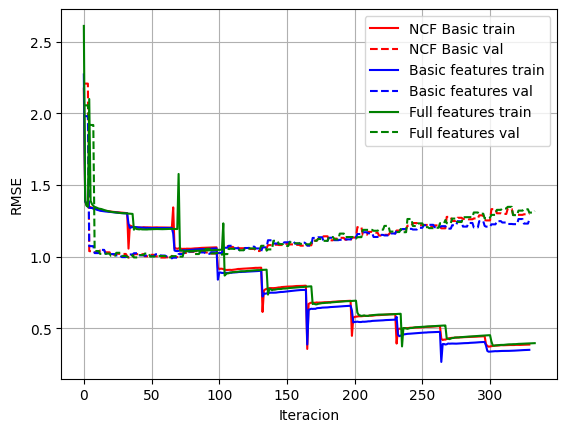

In [ ]:
plt.plot([np.sqrt(log.avg_loss) for log in basic_train_logs], label="NCF Basic train", color="red")
plt.plot([np.sqrt(log.val_loss) for log in basic_train_logs], label="NCF Basic val", color="red", linestyle='--')
plt.plot([np.sqrt(log.avg_loss) for log in basic_features_train_logs], label="Basic features train", color="blue")
plt.plot([np.sqrt(log.val_loss) for log in basic_features_train_logs], label="Basic features val", color="blue", linestyle='--')
plt.plot([np.sqrt(log.avg_loss) for log in full_features_train_logs], label="Full features train", color="green")
plt.plot([np.sqrt(log.val_loss) for log in full_features_train_logs], label="Full features val", color="green", linestyle='--')
plt.xlabel("Iteracion")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.savefig("All_train.png", dpi=300, bbox_inches="tight")


Text(0, 0.5, 'RMSE')

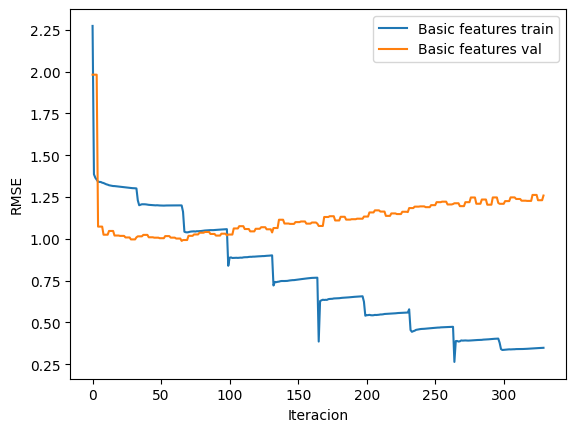

In [ ]:

plt.legend()
plt.xlabel("Iteracion")
plt.ylabel("RMSE")
plt.grid()



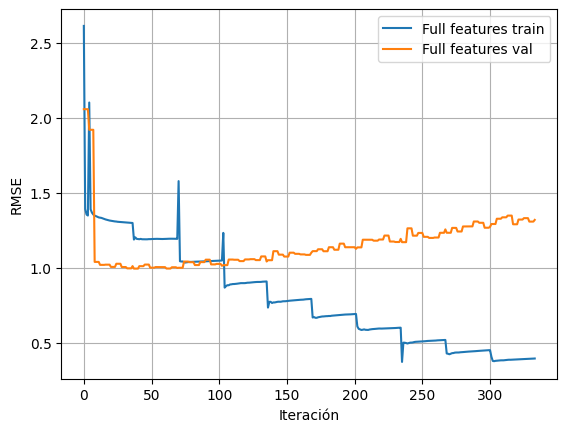

In [ ]:

plt.legend()
plt.xlabel("Iteración")
plt.grid()
plt.ylabel("RMSE")